<a href="https://colab.research.google.com/github/Marcusleeleelee/Git_practice_repository/blob/main/Temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#@title Task 0: Prepare all the utility functions and packages for task 1.

In [3]:
#@title Step 1: Import all necessary libraries

# General python library
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.animation as animation

# Torch library
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
#@title Step 2: Define utility functions

# def load_image(filename):
#   im_pil = Image.open(os.path.join(srcpath, filename))
#   im = np.array(im_pil).astype(np.float32) / 255
#   return im

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def error_performance(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if dataloader.dataset.train == True: print(f"Train Error: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else: print(f"Test Error: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [ ]:
#@title Step 3: Load the MNIST dataset

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Create data loaders.
batch_size = 64    #@param {type:"integer"}
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
#@title Testing block: Print shapes of the input image and the output label

# Note that this channel order in torch is slightly different from slides.

for input_image, _ in test_dataloader:
    print(f"Shape of input image: [Number of images in a batch, No. of channel, Height, Width]: {input_image.shape}")
    break

In [ ]:
 #@title Testing block: Visualize the training n samples
n = 10
plt.figure(figsize=(40, n))
for input_image, ground_truth_label in test_dataloader:
  for i in range(n):
      plt.subplot(int(n/5), 5, i + 1)
      plt.imshow(input_image[i, 0, ...], cmap='gray')
      label_i = int(ground_truth_label[i])
      plt.title(f'Number {label_i}', fontsize=18)
  break

In [ ]:
#@title Task 1: Start

In [46]:
#@title Step 1: Setup a training device and define loss function.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
#@title Step 2: Define the network.

class NeuralNetwork_ANN(nn.Module):
    def __init__(self):
        super().__init__()
        #################################################################
        # Your code goes here.
        #################################################################
        self.network = nn.Sequential(
            nn.Flatten(),             # This flatten image, which converts 28x28 image to 756 vector
            nn.Linear(28*28, 128),    # nn.Linear(a, b) means the input is a channels and the output is b chnnals
            nn.ReLU(),
            nn.Linear(128, 128),      # Similarly, this is 128-channel input and 128-channel output.
            nn.ReLU(),
            nn.Linear(128, 10),       # Since the output is 10-class, so the output must be 10 channels.
            # nn.ReLU(),
        )

    def forward(self, x):
        return self.network(x)

class NeuralNetwork_CNN(nn.Module):
    def __init__(self, lrate = 1e-1, epochs = 10, loss_fn_choice = None, optimizer_choice = None):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                                 # A convolutional network
                                                 # After this layer, the image is 28x28 with 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # nn.MaxPool2d(2, 2) is a 2x2 pooling layer
                                                 # After this layer, the image is 14x14 with 32 channels
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                                 # After this layer, the image is still 14x14 with 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # After this layer, the image is ?x? with 32 channels
            nn.Flatten(),
            nn.Linear(7*7*32, 10)
        )
        self.lrate = lrate
        self.epochs = epochs
        if loss_fn_choice == None: self.loss_fn = nn.CrossEntropyLoss()
        else: self.loss_fn = loss_fn_choice
        if optimizer_choice == None:self.optimizer = torch.optim.SGD(self.parameters(), self.lrate)
        else: self.optimizer = optimizer_choice

    def forward(self, x):
        return self.network(x)

In [52]:
#@title Step 3: Run the CNN-based network training job with 10 epochs.

# Define and train models.
model_1 = NeuralNetwork_CNN().to(device)
accuracy_records_train = []
accuracy_records_test = []  # 2D array to store accuracy and epoch
for t in range(model_1.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_1, model_1.loss_fn, model_1.optimizer)

    accuracy_train = error_performance(train_dataloader, model_1, model_1.loss_fn)
    accuracy_test = error_performance(test_dataloader, model_1, model_1.loss_fn)
    accuracy_records_train.append([accuracy_train, t+1])
    accuracy_records_test.append([accuracy_test, t+1])
print("Done!")

Epoch 1
-------------------------------
loss: 2.309603  [   64/60000]
loss: 0.348440  [ 6464/60000]
loss: 0.153113  [12864/60000]
loss: 0.293579  [19264/60000]
loss: 0.040694  [25664/60000]
loss: 0.138438  [32064/60000]
loss: 0.096681  [38464/60000]
loss: 0.142488  [44864/60000]
loss: 0.230054  [51264/60000]
loss: 0.227447  [57664/60000]
Train Error: 
Accuracy: 96.7%, Avg loss: 0.108296 

Test Error: 
Accuracy: 96.9%, Avg loss: 0.100269 

Epoch 2
-------------------------------
loss: 0.111573  [   64/60000]
loss: 0.125895  [ 6464/60000]
loss: 0.078883  [12864/60000]
loss: 0.155785  [19264/60000]
loss: 0.021059  [25664/60000]
loss: 0.087073  [32064/60000]
loss: 0.102744  [38464/60000]
loss: 0.105073  [44864/60000]
loss: 0.216505  [51264/60000]
loss: 0.136392  [57664/60000]
Train Error: 
Accuracy: 97.9%, Avg loss: 0.064420 

Test Error: 
Accuracy: 97.9%, Avg loss: 0.062384 

Epoch 3
-------------------------------
loss: 0.061009  [   64/60000]
loss: 0.137242  [ 6464/60000]
loss: 0.065837

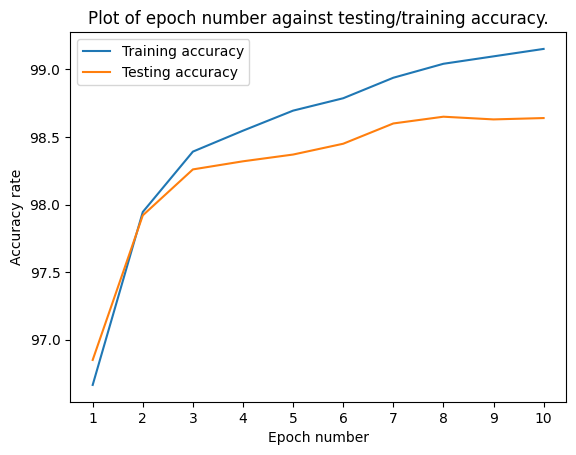

In [53]:
#@title Step 4: Plot the epoch(x-axis)-accuracy(y-axis) curve
def temp_plot_function_1(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy rate')
    plt.title('Plot of epoch number against testing/training accuracy.')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()

temp_plot_function_1(accuracy_records_train, accuracy_records_test, legend = ['Training accuracy', 'Testing accuracy'])

In [ ]:
#@title Step 5: For both CNN-based networks, try different batch size.
import time
model_3 = NeuralNetwork_CNN(epochs = 3).to(device)
accuracy_records_train = []
accuracy_records_test = []
batchsize_accuracy_records_train = []
batchsize_accuracy_records_test = []
batch_size_array = [64 * i for i in range(1,11)]
elapsed_times = []  # List to store elapsed times
for i in batch_size_array:
    start_time = time.time()
    batch_size = i
    for t in range(model_3.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model_3, model_3.loss_fn, model_3.optimizer)
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_times.append([elapsed_time, i])
    accuracy_train = error_performance(train_dataloader, model_3, model_3.loss_fn)
    accuracy_test = error_performance(test_dataloader, model_3, model_3.loss_fn)
    batchsize_accuracy_records_train.append([accuracy_train, i])
    batchsize_accuracy_records_test.append([accuracy_test, i])
print("Done!")

Epoch 1
-------------------------------
loss: 2.310684  [   64/60000]
loss: 0.362473  [ 6464/60000]
loss: 0.177815  [12864/60000]


In [ ]:
#@title Step 6: Plot of batchSize-accuracy curve.
def temp_plot_function_2(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Batch number')
    plt.ylabel('Accuracy rate')
    plt.title('Plot of testing/training accuracy against batch number (Assuming using 3 epochs only).')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()
temp_plot_function_2(batchsize_accuracy_records_train, batchsize_accuracy_records_test, legend = ['Training accuracy', 'Testing accuracy'])

In [ ]:
#@title Step 7: Plot of batchSize-runtime curve.
def temp_plot_function_3(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Batch number')
    plt.ylabel('Runtime(seconds)')
    plt.title('Plot of runtime(seconds) against batch number (Assuming using 3 epochs only).')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()

temp_plot_function_1(elapsed_times, legend = ['Runtime(seconds) per batch number'])